<font size="6">Back to (predict) the future - Interactive M5 EDA</font>

Source: https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda

# Introduction

# Preparations

## Load libraries

In [3]:
from calendar import day_abbr, day_name, month_abbr
from operator import itemgetter

import ipywidgets as widgets
import numpy as np
import pandas as pd
from plotly import express as px
from plotly import figure_factory as ff
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.smoothers_lowess import lowess

ggplot2 = itemgetter(8, 2, 0)(px.colors.qualitative.Dark24)

## Load data

In [2]:
train = pd.read_csv("sales_train_validation.csv")
prices = pd.read_csv("sell_prices.csv")
calendar = pd.read_csv("calendar.csv", parse_dates=["date"])
sample_submit = pd.read_csv("sample_submission.csv")

# Quick Look: File structure and content

## Training sales data

In [9]:
train.iloc[:, :10].head(10)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
5  HOBBIES_1_006_CA_1_validation  HOBBIES_1_006  HOBBIES_1  HOBBIES     CA_1   
6  HOBBIES_1_007_CA_1_validation  HOBBIES_1_007  HOBBIES_1  HOBBIES     CA_1   
7  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
8  HOBBIES_1_009_CA_1_validation  HOBBIES_1_009  HOBBIES_1  HOBBIES     CA_1   
9  HOBBIES_1_010_CA_1_validation  HOBBIES_1_010  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  
0       CA    0    0    0    0  
1       CA    0    0    0    0  
2       CA    0    0    0    0  
3       CA    0    0    0    0  
4       CA    0    0    0    0  
5       CA    0    0    0    0  
6       CA    0    0    0    0  
7       CA   12   15    0    0  
8       CA    2    0    7    3  
9       CA    0    0    1    0

In [4]:
train.id.str.split("_").str[-1].value_counts()

validation    30490
Name: id, dtype: int64

## Sales prices

In [5]:
prices.head(10)

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26
5     CA_1  HOBBIES_1_001     11330        8.26
6     CA_1  HOBBIES_1_001     11331        8.26
7     CA_1  HOBBIES_1_001     11332        8.26
8     CA_1  HOBBIES_1_001     11333        8.26
9     CA_1  HOBBIES_1_001     11334        8.26

In [6]:
prices.describe(include=[object])

store_id      item_id
count   6841121      6841121
unique       10         3049
top        TX_2  FOODS_3_311
freq     701214         2820

In [14]:
prices.describe(exclude=[object])

wm_yr_wk    sell_price
count  6.841121e+06  6.841121e+06
mean   1.138294e+04  4.410952e+00
std    1.486100e+02  3.408814e+00
min    1.110100e+04  1.000000e-02
25%    1.124700e+04  2.180000e+00
50%    1.141100e+04  3.470000e+00
75%    1.151700e+04  5.840000e+00
max    1.162100e+04  1.073200e+02

## Calendar

In [8]:
calendar.head(8)

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   
5  2011-02-03     11101   Thursday     6      2  2011  d_6          NaN   
6  2011-02-04     11101     Friday     7      2  2011  d_7          NaN   
7  2011-02-05     11102   Saturday     1      2  2011  d_8          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  
5          NaN          NaN          NaN        1        1        1  
6          NaN          NaN          NaN        1        0        0  
7          NaN          NaN          NaN        1        1        1

In [16]:
calendar.T

0                    1                    2     \
date          2011-01-29 00:00:00  2011-01-30 00:00:00  2011-01-31 00:00:00   
wm_yr_wk                    11101                11101                11101   
weekday                  Saturday               Sunday               Monday   
wday                            1                    2                    3   
month                           1                    1                    1   
year                         2011                 2011                 2011   
d                             d_1                  d_2                  d_3   
event_name_1                  NaN                  NaN                  NaN   
event_type_1                  NaN                  NaN                  NaN   
event_name_2                  NaN                  NaN                  NaN   
event_type_2                  NaN                  NaN                  NaN   
snap_CA                         0                    0                    0   
snap_TX                         0                    0                    0   
snap_WI                         0                    0                    0   

                             3                    4                    5     \
date          2011-02-01 00:00:00  2011-02-02 00:00:00  2011-02-03 00:00:00   
wm_yr_wk                    11101                11101                11101   
weekday                   Tuesday            Wednesday             Thursday   
wday                            4                    5                    6   
month                           2                    2                    2   
year                         2011                 2011                 2011   
d                             d_4                  d_5                  d_6   
event_name_1                  NaN                  NaN                  NaN   
event_type_1                  NaN                  NaN                  NaN   
event_name_2                  NaN                  NaN                  NaN   
event_type_2                  NaN                  NaN                  NaN   
snap_CA                         1                    1                    1   
snap_TX                         1                    0                    1   
snap_WI                         0                    1                    1   

                             6                    7                    8     \
date          2011-02-04 00:00:00  2011-02-05 00:00:00  2011-02-06 00:00:00   
wm_yr_wk                    11101                11102                11102   
weekday                    Friday             Saturday               Sunday   
wday                            7                    1                    2   
month                           2                    2                    2   
year                         2011                 2011                 2011   
d                             d_7                  d_8                  d_9   
event_name_1                  NaN                  NaN            SuperBowl   
event_type_1                  NaN                  NaN             Sporting   
event_name_2                  NaN                  NaN                  NaN   
event_type_2                  NaN                  NaN                  NaN   
snap_CA                         1                    1                    1   
snap_TX                         0                    1                    1   
snap_WI                         0                    1                    1   

                             9     ...                 1959  \
date          2011-02-07 00:00:00  ...  2016-06-10 00:00:00   
wm_yr_wk                    11102  ...                11619   
weekday                    Monday  ...               Friday   
wday                            3  ...                    7   
month                           2  ...                    6   
year                         2011  ...                 2016   
d                            d

In [9]:
calendar.describe(include=[object])

weekday      d event_name_1 event_type_1  event_name_2 event_type_2
count       1969   1969          162          162             5            5
unique         7   1969           30            4             4            2
top     Saturday  d_307  MemorialDay    Religious  Father's day     Cultural
freq         282      1            6           55             2            4

In [13]:
calendar.describe(exclude=[object], datetime_is_numeric=True)

date      wm_yr_wk         wday        month  \
count                 1969   1969.000000  1969.000000  1969.000000   
mean   2013-10-09 00:00:00  11347.086338     3.997461     6.325546   
min    2011-01-29 00:00:00  11101.000000     1.000000     1.000000   
25%    2012-06-04 00:00:00  11219.000000     2.000000     3.000000   
50%    2013-10-09 00:00:00  11337.000000     4.000000     6.000000   
75%    2015-02-13 00:00:00  11502.000000     6.000000     9.000000   
max    2016-06-19 00:00:00  11621.000000     7.000000    12.000000   
std                    NaN    155.277043     2.001141     3.416864   

              year      snap_CA      snap_TX      snap_WI  
count  1969.000000  1969.000000  1969.000000  1969.000000  
mean   2013.288471     0.330117     0.330117     0.330117  
min    2011.000000     0.000000     0.000000     0.000000  
25%    2012.000000     0.000000     0.000000     0.000000  
50%    2013.000000     0.000000     0.000000     0.000000  
75%    2015.000000     1.000000     1.000000     1.000000  
max    2016.000000     1.000000     1.000000     1.000000  
std       1.580198     0.470374     0.470374     0.470374

## Missing values & zero values

In [11]:
train.isna().sum().sum()

0

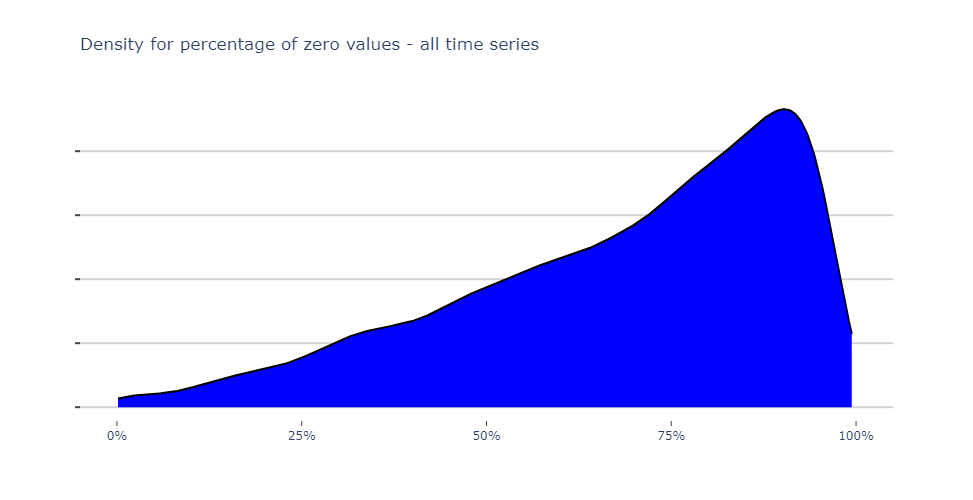

In [33]:
bar = train.filter(regex="^((?!id).)*$").eq(0)
bar = pd.DataFrame(dict(sum=bar.sum(1), mean=bar.mean(1)))

fig = ff.create_distplot(
    bar[["mean"]].T.values, ["mean"], colors=["black"], show_hist=False, show_rug=False
)
fig.update_traces(dict(fill="tozeroy", fillcolor="blue"))
fig.update_layout(
    height=500,
    width=800,
    showlegend=False,
    title=dict(text="Density for percentage of zero values - all time series", xref="paper", x=0),
    xaxis=dict(
        zeroline=False,
        range=(-0.05, 1.05),
        showgrid=False,
        ticks="outside",
        dtick=0.25,
        tickformat="%",
    ),
    yaxis=dict(
        zeroline=False,
        range=(-0.1, 2.4),
        ticks="outside",
        showticklabels=False,
        gridcolor="lightgray",
        gridwidth=2,
        tickwidth=2,
    ),
    plot_bgcolor="white",
)
fig.show()

# Visual Overview: Interactive time series plots

In [3]:
def extract_ts(df):
    df["id"] = df.id.str.rstrip("_validation")
    df = df.filter(regex="(^id$|^d_)")
    df = df.rename(
        lambda x: min_date + pd.to_timedelta(int(x.lstrip("d_")) - 1, "D")
        if x.startswith("d_")
        else x,
        axis=1,
    )
    return df.melt(id_vars=["id"], var_name="dates", value_name="sales")


foo = train.sample(50, random_state=4321).sort_values("id")
min_date = calendar.date[0]
ts_out = extract_ts(foo)

## Individual item-level time series - random sample

In [197]:
fig = go.FigureWidget(px.line(ts_out, x="dates", y="sales", color="id", width=800, height=500))
fig.update_layout(
    xaxis=dict(title="Date", showgrid=False, ticks="outside"),
    yaxis=dict(title="Sales", showgrid=False, ticks="outside"),
    plot_bgcolor="white",
)
for trace in fig.data:
    trace.visible = False
select_multiple = widgets.SelectMultiple(options=ts_out.id.unique())


def response(change):
    with fig.batch_update():
        for trace in fig.data:
            trace.visible = None if trace.name in select_multiple.value else False


select_multiple.observe(response, names="value")
label = widgets.Label(
    r"$\textbf{Sales over time: Select a time series ID (select with CTRL+LMB key):}$"
)
widgets.VBox([label, select_multiple, fig])

## All aggregate sales

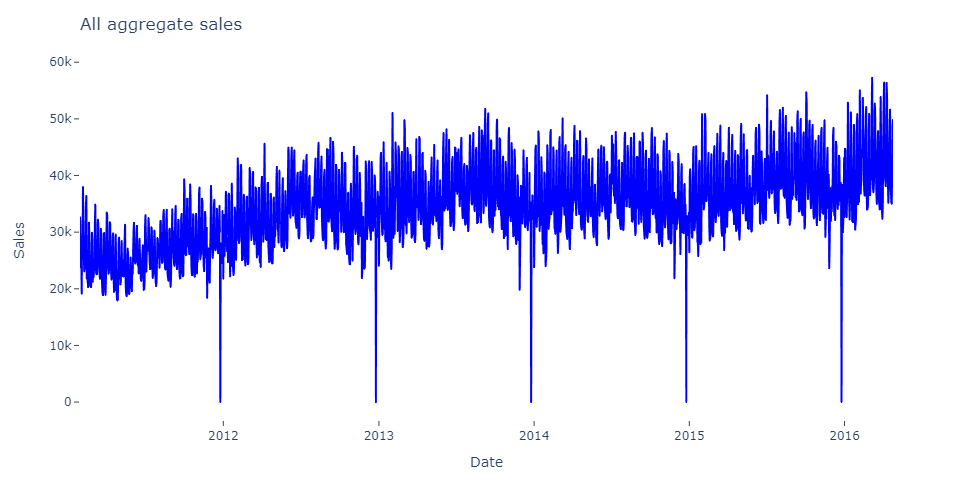

In [340]:
foo = train.filter(regex="^d_").sum().to_frame().T.assign(id="1")
bar = extract_ts(foo)

fig = px.line(bar, x="dates", y="sales", color_discrete_sequence=["blue"])
fig.update_layout(
    width=800,
    height=500,
    title=dict(text="All aggregate sales", xref="paper", x=0),
    xaxis=dict(title="Date", showgrid=False, ticks="outside"),
    yaxis=dict(title="Sales", showgrid=False, ticks="outside"),
    plot_bgcolor="white",
)

## Sales per State

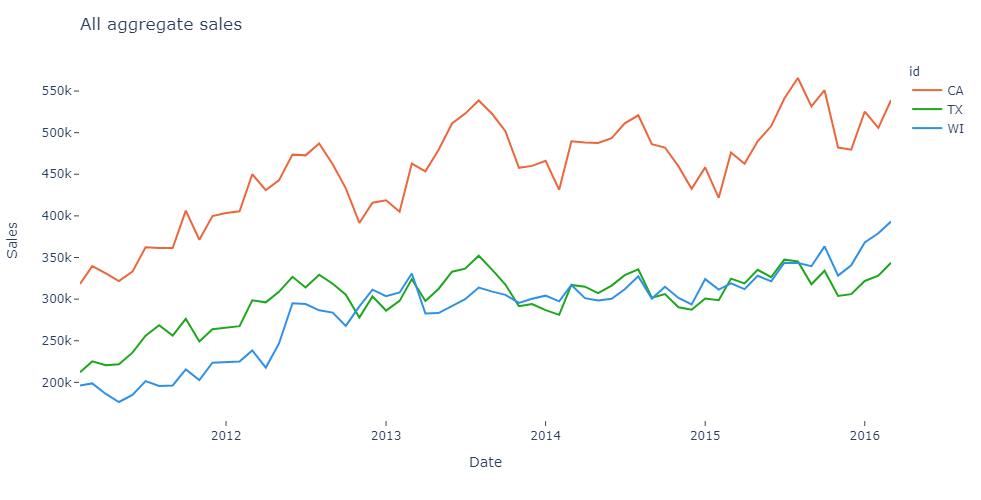

In [158]:
foo = train.groupby("state_id").sum().reset_index().rename(columns={"state_id": "id"})
bar = extract_ts(foo)
bar["month"] = bar.dates.dt.month
bar["year"] = bar.dates.dt.year
bar = bar.groupby(["id", "year", "month"]).agg(sales=("sales", "sum"), dates=("dates", "min"))
bar = bar.reset_index()
bar = bar[bar.dates.astype(str).str.match("....-..-01")]
bar = bar[bar.dates != bar.dates.max()]

fig = px.line(bar, x="dates", y="sales", color="id", color_discrete_sequence=ggplot2)
fig.update_layout(
    width=800,
    height=500,
    title=dict(text="All aggregate sales", xref="paper", x=0),
    xaxis=dict(title="Date", showgrid=False, ticks="outside"),
    yaxis=dict(title="Sales", showgrid=False, ticks="outside"),
    plot_bgcolor="white",
)

## Sales per Store & Category

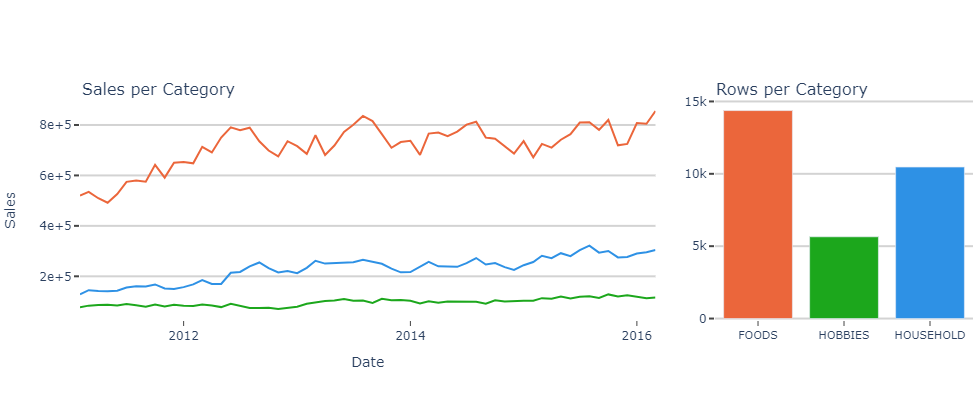

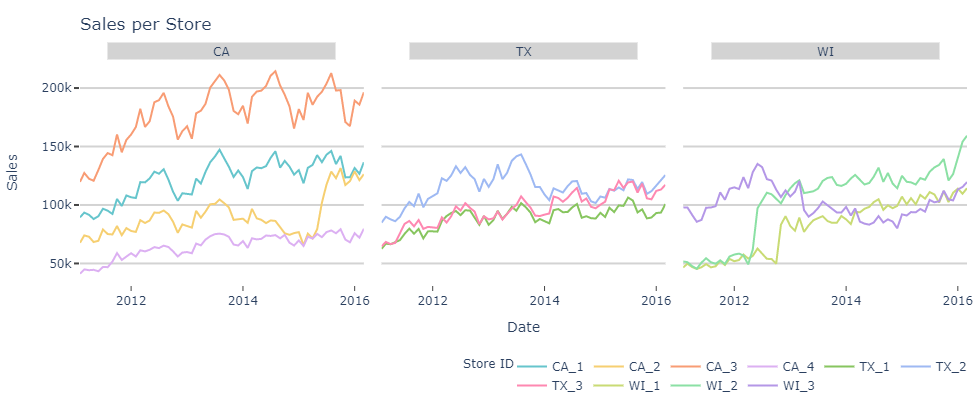

In [163]:
foo = train.groupby("cat_id").sum().reset_index().rename(columns={"cat_id": "id"})
p1 = extract_ts(foo)
p1["month"] = p1.dates.dt.month
p1["year"] = p1.dates.dt.year
p1 = p1.groupby(["id", "year", "month"]).agg(sales=("sales", "sum"), dates=("dates", "min"))
p1 = p1.reset_index()
p1 = p1[p1.dates.astype(str).str.match("....-..-01")]
p1 = p1[p1.dates != p1.dates.max()]

p12 = make_subplots(
    cols=3,
    specs=[[{"colspan": 2}, None, {}]],
    subplot_titles=("Sales per Category", "Rows per Category"),
)
p1 = px.line(p1, x="dates", y="sales", color="id", color_discrete_sequence=ggplot2)
p2 = px.bar(
    pd.DataFrame(train.cat_id.value_counts()).sort_index().reset_index(),
    color="index",
    color_discrete_sequence=ggplot2,
)
p12.add_traces(p1.data)
p12.add_traces(p2.data, rows=[1] * len(p2.data), cols=[3] * len(p2.data))
p12.update_layout(
    width=800,
    height=400,
    barmode="relative",
    showlegend=False,
    xaxis=dict(title="Date", nticks=3, showgrid=False, ticks="outside"),
    yaxis=dict(
        title="Sales",
        nticks=5,
        ticks="outside",
        tickformat="e",
        gridcolor="lightgray",
        gridwidth=2,
        tickwidth=2,
    ),
    xaxis2=dict(
        title="",
        ticks="outside",
        tickmode="array",
        tickvals=list(range(len(p2.data))),
        ticktext=[trace.name for trace in p2.data],
        tickangle=0,
        tickfont_size=11,
    ),
    yaxis2=dict(
        title="",
        ticks="outside",
        dtick=5000,
        tickwidth=2,
        range=(-100, 15100),
        zeroline=False,
        gridcolor="lightgray",
        gridwidth=2,
    ),
    plot_bgcolor="white",
    margin_r=0,
)
p12.layout.annotations[0].update(x=0, xanchor="left")
p12.layout.annotations[1].update(x=0.71, xanchor="left")
p12.show()

bar = train.groupby("store_id").sum().reset_index().rename(columns={"store_id": "id"})
p3 = extract_ts(bar)
p3["month"] = p3.dates.dt.month
p3["year"] = p3.dates.dt.year
p3 = p3.groupby(["id", "year", "month"]).agg(sales=("sales", "sum"), dates=("dates", "min"))
p3 = p3.reset_index()
p3 = p3[p3.dates.astype(str).str.match("....-..-01")]
p3 = p3[p3.dates != p3.dates.max()]
p3["state_id"] = p3.id.str[:2]

p3 = px.line(
    p3,
    x="dates",
    y="sales",
    color="id",
    facet_col="state_id",
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
p3.for_each_annotation(
    lambda a: a.update(text=a.text.split("=")[-1], bgcolor="lightgray", width=225)
)
p3.update_xaxes(title="", ticks="outside", nticks=3)
p3.update_yaxes(title="", gridcolor="lightgray", gridwidth=2)
p3.update_layout(
    width=800,
    height=400,
    title=dict(text="Sales per Store", xref="paper", x=0),
    xaxis2=dict(title="Date"),
    yaxis=dict(title="Sales", nticks=5, ticks="outside", tickwidth=2),
    plot_bgcolor="white",
    legend=dict(title="Store ID", orientation="h", xanchor="left", x=1, y=-0.3),
    margin_r=0,
)
p3.show()

## Sales per Department

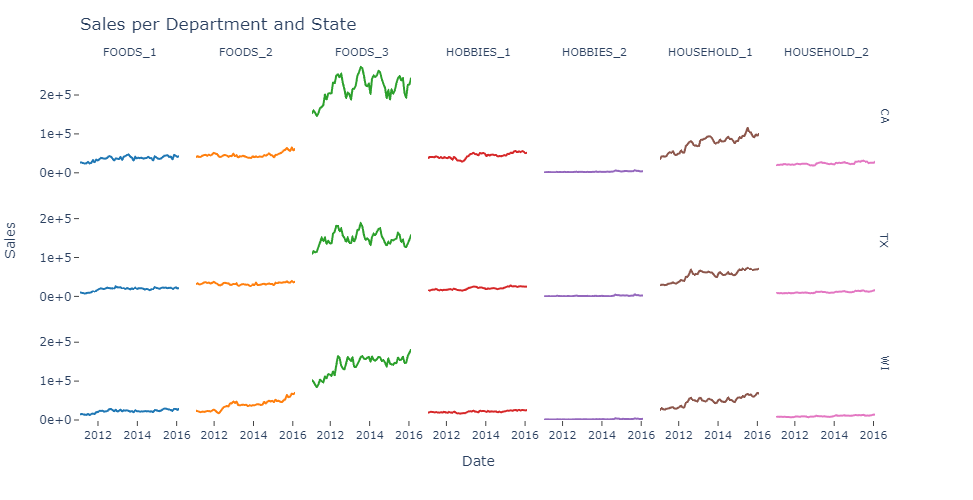

In [16]:
foo = train.groupby(["state_id", "dept_id"]).sum().reset_index()
foo = foo.rename(
    lambda x: min_date + pd.to_timedelta(int(x.lstrip("d_")) - 1, "D") if x.startswith("d_") else x,
    axis=1,
)
foo = foo.melt(id_vars=["state_id", "dept_id"], var_name="dates", value_name="sales")
foo["month"] = foo.dates.dt.month
foo["year"] = foo.dates.dt.year
foo = foo.groupby(["state_id", "dept_id", "year", "month"])
foo = foo.agg(sales=("sales", "sum"), dates=("dates", "min")).reset_index()
foo = foo[foo.dates.astype(str).str.match("....-..-01")]
foo = foo[foo.dates != foo.dates.max()]

fig = px.line(
    foo,
    x="dates",
    y="sales",
    color="dept_id",
    facet_col="dept_id",
    facet_row="state_id",
    color_discrete_sequence=px.colors.qualitative.D3,
)
fig.update_xaxes(title="", ticks="outside", nticks=3, tickangle=0, row=1, tickfont_size=11)
fig.update_yaxes(
    title="", ticks="outside", tickformat="e", tick0=0, col=1, nticks=3, range=(0, 2.9e5)
)
fig.update_layout(
    width=800,
    height=500,
    showlegend=False,
    title=dict(text="Sales per Department and State", xref="paper", x=0),
    xaxis4=dict(title="Date"),
    yaxis8=dict(title="Sales"),
    plot_bgcolor="white",
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1], font_size=11))
fig.show()

## Seasonalities - global

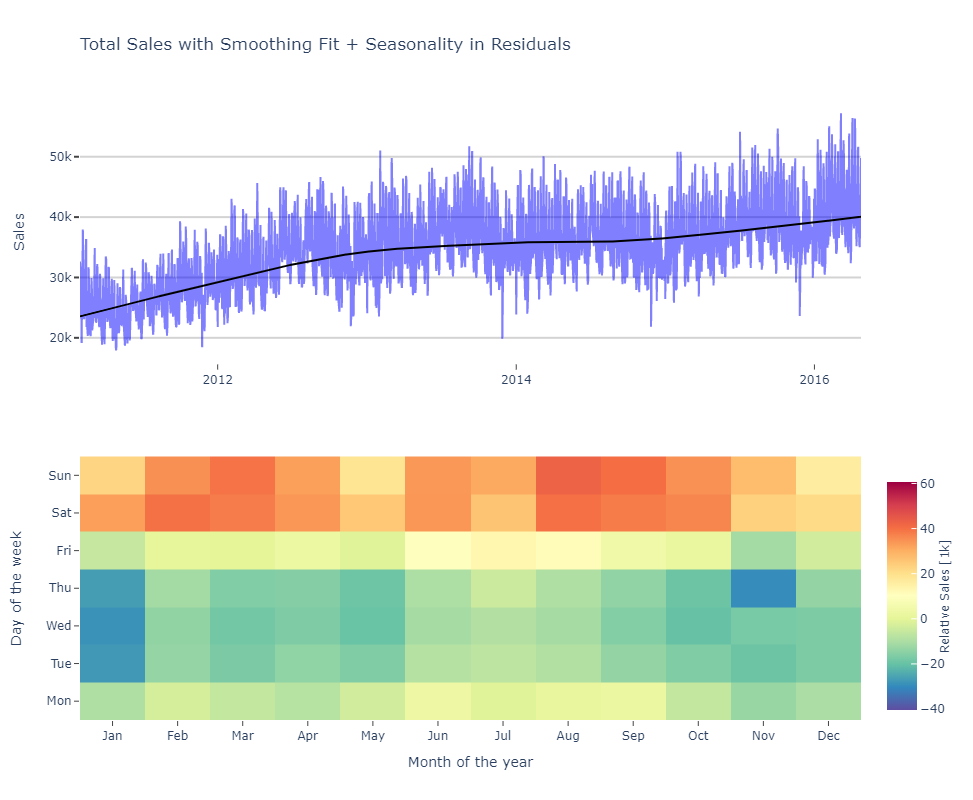

In [300]:
foo = train.filter(regex="^d_").sum().to_frame().T.assign(id="1")
bar = extract_ts(foo)
bar = bar[~bar["dates"].astype(str).str.endswith("-12-25")]
x = (bar.dates - bar.dates.min()).dt.days + 1
bar["loess"] = lowess(bar.sales, x, frac=1 / 2, return_sorted=False)
bar["sales_rel"] = bar.sales - bar.loess
bar["wday"] = bar.dates.dt.day_name().str[:3]
bar["month"] = bar.dates.dt.month_name().str[:3]
bar["year"] = bar.dates.dt.year
p2 = bar.groupby(["year", "month", "wday"]).agg(sales=("sales_rel", lambda x: sum(x) / 1e3))
p2_mean = p2.groupby(level=[1, 2]).mean().unstack().sales.T.loc[day_abbr[:], month_abbr[1:]]

fig = make_subplots(rows=2)
fig.add_trace(go.Scatter(x=bar.dates, y=bar.sales, line_color="blue", opacity=0.5), row=1, col=1)
fig.add_trace(go.Scatter(x=bar.dates, y=bar.loess, line_color="black"), row=1, col=1)
fig.add_trace(
    go.Heatmap(
        x=p2_mean.columns,
        y=p2_mean.index,
        z=p2_mean,
        colorscale="Spectral",
        reversescale=True,
        zmin=p2.min()[0],
        zmax=p2.max()[0],
        showscale=True,
        colorbar=dict(
            title="Relative Sales [1k]",
            title_side="right",
            y=0.2,
            len=0.4,
            ticks="inside",
            tickcolor="white",
        ),
    ),
    row=2,
    col=1,
)
fig.update_layout(
    width=800,
    height=800,
    showlegend=False,
    title=dict(text="Total Sales with Smoothing Fit + Seasonality in Residuals", xref="paper", x=0),
    xaxis=dict(title="", showgrid=False, ticks="outside", nticks=3),
    yaxis=dict(
        title="Sales", gridcolor="lightgray", ticks="outside", dtick=1e4, tickwidth=2, gridwidth=2
    ),
    xaxis2=dict(title="Month of the year", ticks="outside"),
    yaxis2=dict(title="Day of the week", ticks="outside"),
    plot_bgcolor="white",
)
fig.show()

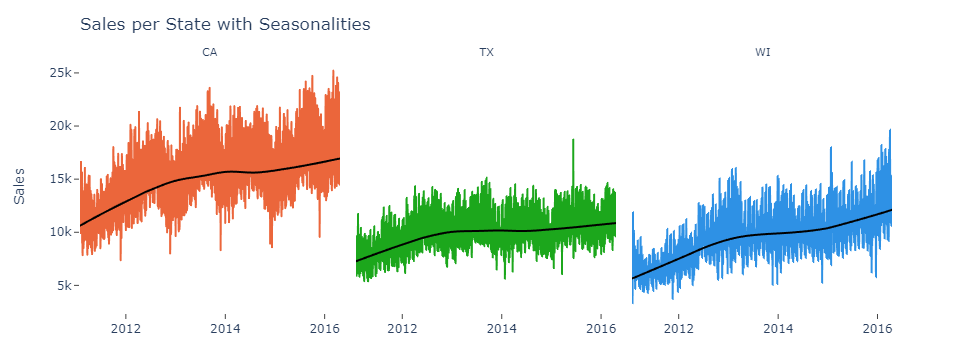

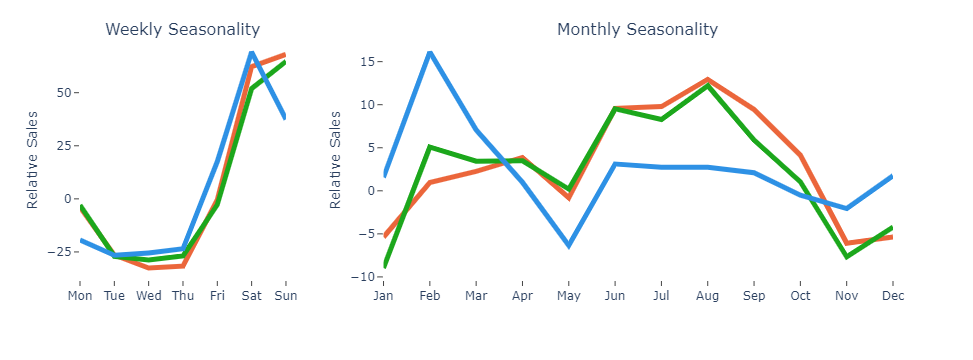

In [206]:
foo = train.groupby("state_id").sum().reset_index().rename(columns={"state_id": "id"})
bar = extract_ts(foo)
bar = bar[~bar["dates"].astype(str).str.endswith("-12-25")]
bar = (
    bar.groupby("id")
    .apply(
        lambda x: pd.DataFrame(
            dict(
                loess=lowess(
                    x["sales"],
                    (x["dates"] - x["dates"].min()).dt.days + 1,
                    frac=0.5,
                    return_sorted=False,
                ),
                mean_sales=x["sales"].mean(),
                sales=x["sales"].values,
            ),
            index=x["dates"],
        )
    )
    .reset_index()
)
bar["sales_rel"] = (bar.sales - bar.loess) / bar.mean_sales

p1 = px.line(
    bar, x="dates", y="sales", color="id", facet_col="id", color_discrete_sequence=ggplot2,
)
p1_loess = (
    bar.groupby("id")
    .apply(
        lambda x: pd.Series(
            lowess(
                x["sales"],
                (x["dates"] - x["dates"].min()).dt.days + 1,
                frac=0.5,
                return_sorted=False,
            ),
            x["dates"],
        )
    )
    .stack()
    .to_frame("loess")
)
p1_loess = px.line(bar, x="dates", y="loess", facet_col="id", color_discrete_sequence=["black"])
p1.add_traces(p1_loess.data, rows=[1, 1, 1], cols=[1, 2, 3])
p1.update_xaxes(title="", ticks="outside")
p1.update_layout(
    width=800,
    height=350,
    showlegend=False,
    title=dict(text="Sales per State with Seasonalities", xref="paper", x=0),
    yaxis=dict(title="Sales", ticks="outside"),
    plot_bgcolor="white",
    margin_b=0,
)
p1.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1], font_size=11))
p1.show()

bar["wday"] = bar.dates.dt.day_name().str[:3]
bar["month"] = bar.dates.dt.month_name().str[:3]
fig = make_subplots(
    cols=3,
    specs=[[{}, {"colspan": 2}, None]],
    subplot_titles=["Weekly Seasonality", "Monthly Seasonality"],
    horizontal_spacing=0.12,
)
p2 = bar.groupby(["id", "wday"])["sales_rel"].sum()
p2 = p2.unstack()[day_abbr[:]].stack().reset_index().rename(columns={0: "sales"})
p2 = px.line(p2, "wday", "sales", color="id", color_discrete_sequence=ggplot2)
fig.add_traces(p2.data, rows=[1] * len(p2.data), cols=[1] * len(p2.data))
p3 = bar.groupby(["id", "month"])["sales_rel"].sum()
p3 = p3.unstack()[month_abbr[1:]].stack().reset_index().rename(columns={0: "sales"})
p3 = px.line(p3, "month", "sales", color="id", color_discrete_sequence=ggplot2)
fig.add_traces(p3.data, rows=[1] * len(p3.data), cols=[2] * len(p3.data))
fig.update_traces(line_width=5)
fig.update_xaxes(title="", ticks="outside")
fig.update_yaxes(title=dict(text="Relative Sales", standoff=0), ticks="outside")
fig.update_layout(
    width=800,
    height=300,
    showlegend=False,
    yaxis_dtick=25,
    yaxis2_dtick=5,
    plot_bgcolor="white",
    margin_t=40,
)
fig.show()

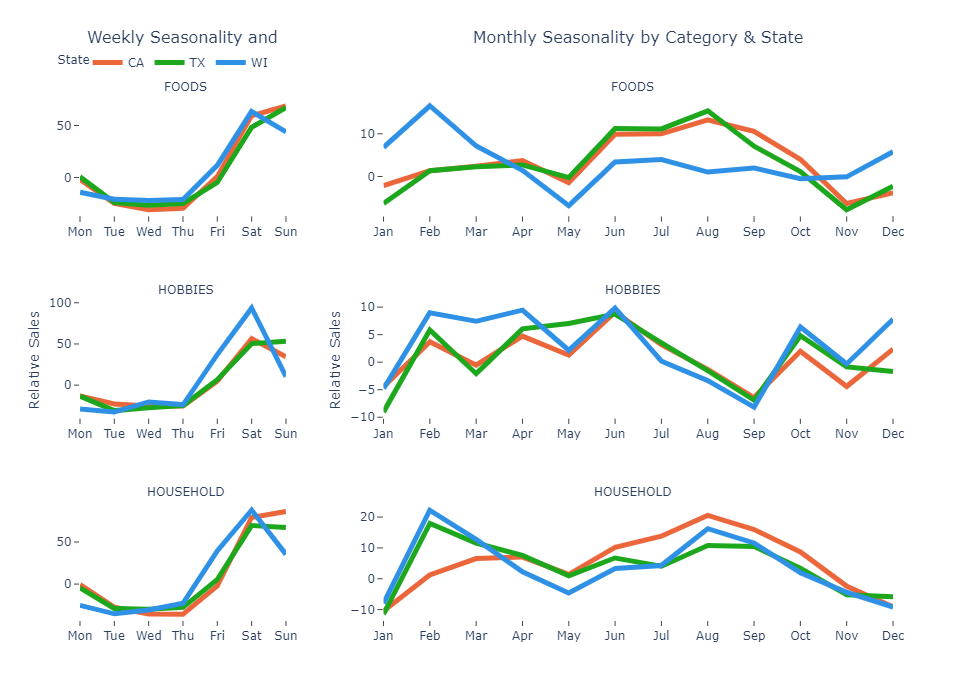

In [354]:
foo = train.groupby(["cat_id", "state_id"]).sum().reset_index()
foo = foo.rename(
    lambda x: min_date + pd.to_timedelta(int(x.lstrip("d_")) - 1, "D") if x.startswith("d_") else x,
    axis=1,
)
foo = foo.melt(id_vars=["cat_id", "state_id"], var_name="dates", value_name="sales")
bar = foo[~foo["dates"].astype(str).str.endswith("-12-25")]

bar = (
    bar.groupby(["cat_id", "state_id"])
    .apply(
        lambda x: pd.DataFrame(
            dict(
                loess=lowess(
                    x["sales"],
                    (x["dates"] - x["dates"].min()).dt.days + 1,
                    frac=2 / 3,
                    return_sorted=False,
                ),
                mean_sales=x["sales"].mean(),
                sales=x["sales"].values,
            ),
            index=x["dates"],
        )
    )
    .reset_index()
)
bar["sales_rel"] = (bar.sales - bar.loess) / bar.mean_sales
bar["wday"] = bar.dates.dt.day_name().str[:3]
bar["month"] = bar.dates.dt.month_name().str[:3]

p1 = bar.groupby(["cat_id", "state_id", "wday"])["sales_rel"].sum()
p1 = p1.unstack()[day_abbr[:]].stack().reset_index().rename(columns={0: "sales"})
p1 = px.line(
    p1,
    x="wday",
    y="sales",
    color="state_id",
    facet_col="cat_id",
    facet_col_wrap=1,
    color_discrete_sequence=ggplot2,
)
p2 = bar.groupby(["cat_id", "state_id", "month"])["sales_rel"].sum()
p2 = p2.unstack()[month_abbr[1:]].stack().reset_index().rename(columns={0: "sales"})
p2 = px.line(
    p2,
    x="month",
    y="sales",
    color="state_id",
    facet_col="cat_id",
    facet_col_wrap=1,
    color_discrete_sequence=ggplot2,
)

fig = make_subplots(
    rows=3,
    cols=3,
    specs=[[{}, {"colspan": 2}, None]] * 3,
    subplot_titles=["Weekly Seasonality and", "Monthly Seasonality by Category & State"],
    horizontal_spacing=0.12,
)
fig.add_traces(p1.data, rows=[1, 2, 3] * 3, cols=[1] * 9)
fig.add_traces(p2.data, rows=[1, 2, 3] * 3, cols=[2] * 9)
fig.update_traces(line_width=5)
fig.update_traces(showlegend=False, col=2)
fig.update_xaxes(title="", ticks="outside")
fig.update_yaxes(title=dict(text="", standoff=0), ticks="outside")
fig.update_layout(
    width=800,
    height=700,
    plot_bgcolor="white",
    yaxis3=dict(title=dict(text="Relative Sales")),
    yaxis4=dict(title=dict(text="Relative Sales")),
    legend=dict(
        title=dict(text="State", side="left"),
        orientation="h",
        x=-0.03,
        y=1.1,
        itemsizing="constant",
    ),
)
fig.update_annotations(dict(y=1.1))
for i in range(3):
    text = p1.layout.annotations[i].text.split("=")[-1]
    fig.add_annotation(
        x=0.13,
        xanchor="center",
        xref="paper",
        text=text,
        showarrow=False,
        y=0.23 + i * 0.39,
        yanchor="bottom",
        yref="paper",
    )
    fig.add_annotation(
        x=0.68,
        xanchor="center",
        xref="paper",
        text=text,
        showarrow=False,
        y=0.23 + i * 0.39,
        yanchor="bottom",
        yref="paper",
    )
fig

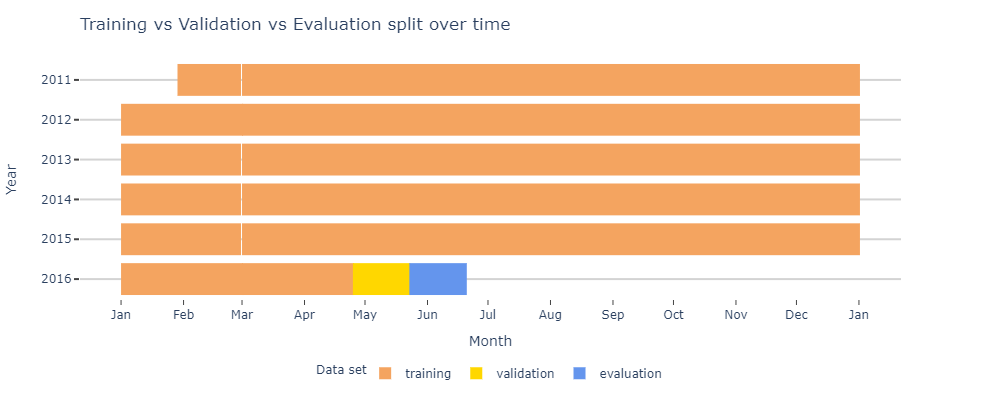

In [70]:
foo = extract_ts(train.head(1).copy()).dates.to_frame()
bar = (pd.Series(np.repeat(foo.dates.max(), 28)) + pd.to_timedelta(range(1, 29), "D")).to_frame(
    "dates"
)
foobar = (pd.Series(np.repeat(bar.dates.max(), 28)) + pd.to_timedelta(range(1, 29), "D")).to_frame(
    "dates"
)
foo = pd.concat({"training": foo, "validation": bar, "evaluation": foobar}, names=["dset"])
foo = foo.reset_index()
foo["year"] = foo.dates.dt.year
foo["dates"] = pd.to_datetime(foo.dates.astype(str).str.replace("[0-9]{4}", "2016"))
foo["month"] = foo.dates.dt.month
foo["pre_march"] = foo.month < 3
foo = (
    foo.groupby(["year", "dset", "pre_march"], sort=False)["dates"]
    .agg(["max", "min"])
    .reset_index()
)
foo["max"] = foo["max"] + pd.to_timedelta(1.5, "D")

fig = px.timeline(
    foo,
    x_start="min",
    x_end="max",
    y="year",
    color="dset",
    color_discrete_sequence=["sandybrown", "gold", "cornflowerblue"],
)
fig.update_traces(dict(marker=dict(line=dict(width=0))))
fig.update_yaxes(autorange="reversed")
fig.update_layout(
    width=800,
    height=400,
    title=dict(text="Training vs Validation vs Evaluation split over time", xref="paper", x=0),
    plot_bgcolor="white",
    legend=dict(title="Data set", orientation="h", x=0.5, xanchor="center", y=-0.25),
    xaxis=dict(title="Month", tickformat="%b", ticks="outside", dtick="M1"),
    yaxis=dict(title="Year", ticks="outside", gridcolor="lightgray", tickwidth=2, gridwidth=2),
)
fig.show()

# Explanatory Variables: Prices and Calendar

## Calendar

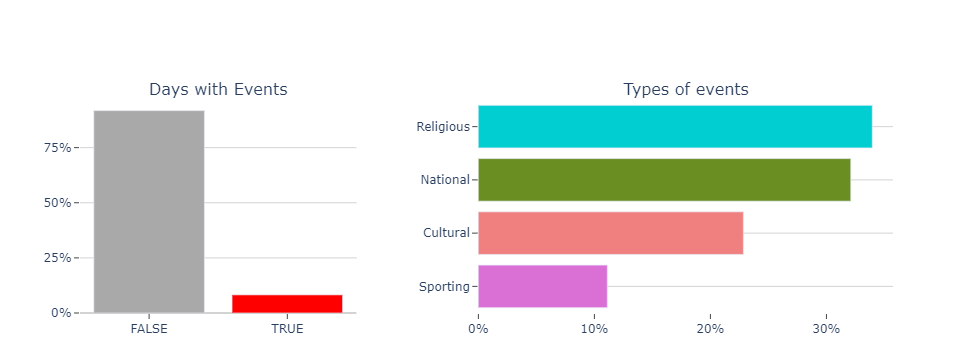

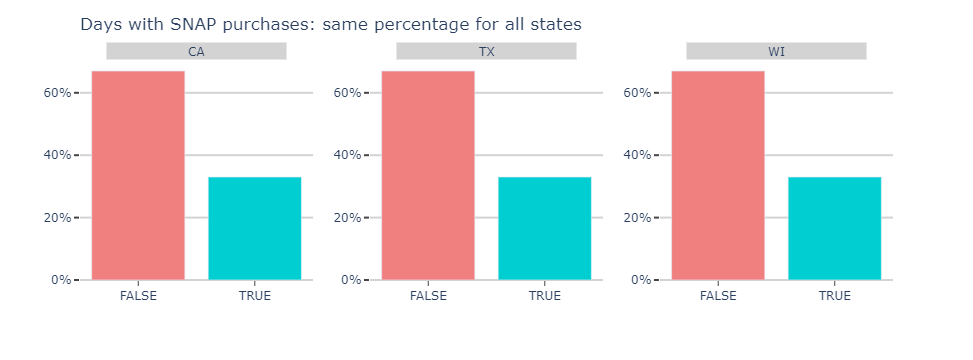

In [977]:
p1 = calendar.event_type_1.notnull().value_counts()
p1 = p1 / p1.sum()
p1 = go.Bar(x=p1.index, y=p1.values, marker_color=["darkgray", "red"])
p2 = calendar.event_type_1.value_counts()
p2 = p2 / p2.sum()
p2 = go.Bar(
    x=p2.values,
    y=p2.index,
    marker_color=["darkturquoise", "olivedrab", "lightcoral", "orchid"],
    orientation="h",
)
fig = make_subplots(
    cols=2,
    column_widths=[0.4, 0.6],
    horizontal_spacing=0.15,
    subplot_titles=["Days with Events", "Types of events"],
)
fig.add_trace(p1)
fig.add_trace(p2, row=1, col=2)
fig.update_layout(
    width=800,
    height=250,
    showlegend=False,
    xaxis=dict(title="", ticks="outside", tickvals=[False, True], ticktext=["FALSE", "TRUE"]),
    yaxis=dict(
        title="",
        ticks="outside",
        tickformat="%",
        dtick=0.25,
        gridcolor="lightgray",
        zerolinecolor="lightgray",
    ),
    xaxis2=dict(title="", ticks="outside", tickformat="%", dtick=0.1),
    yaxis2=dict(title="", ticks="outside", gridcolor="lightgray", autorange="reversed"),
    plot_bgcolor="white",
    margin_b=0,
)
fig.show()

p3 = calendar.filter(regex="snap.*").melt(var_name="state", value_name="snap")
p3["state"] = p3.state.str[5:7]
p3 = p3.groupby(["state"])["snap"].value_counts(normalize=True)
p3.name = "perc"
p3 = p3.reset_index()
fig = px.bar(
    p3,
    x="snap",
    y="perc",
    color="snap",
    facet_col="state",
    facet_col_spacing=0.07,
    color_continuous_scale=["lightcoral", "darkturquoise"],
)
fig.for_each_annotation(
    lambda a: a.update(text=a.text.split("=")[-1], bgcolor="lightgray", width=177)
)
fig.update_xaxes(title="", ticks="outside", tickvals=[0, 1], ticktext=["FALSE", "TRUE"])
fig.update_yaxes(
    zerolinecolor="lightgray",
    title="",
    gridcolor="lightgray",
    ticks="outside",
    gridwidth=2,
    tickformat="%",
    dtick=0.2,
    tickwidth=2,
    showticklabels=True,
)
fig.update_layout(
    width=800,
    height=250,
    title=dict(text="Days with SNAP purchases: same percentage for all states", xref="paper", x=0),
    plot_bgcolor="white",
    coloraxis_showscale=False,
)
fig.show()

In [455]:
foo = calendar.filter(regex="(date|snap.*)").melt(
    id_vars="date", var_name="state", value_name="snap"
)
foo["state"] = foo.state.str[5:7]
foo["year"] = foo.date.dt.year
foo["month"] = foo.date.dt.month
foo["mweek"] = (
    (foo.date.dt.dayofyear - 1) // 7
    - (pd.to_datetime(foo.date.astype(str).str[:-2] + "01").dt.dayofyear - 1) // 7
    + 1
)
foo["wday.lbl"] = foo.date.dt.day_name()
foo["month.lbl"] = foo.date.dt.month_name()

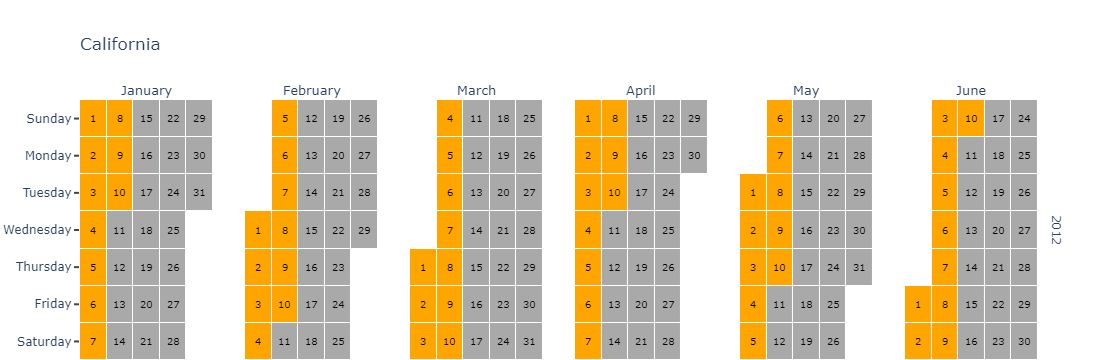

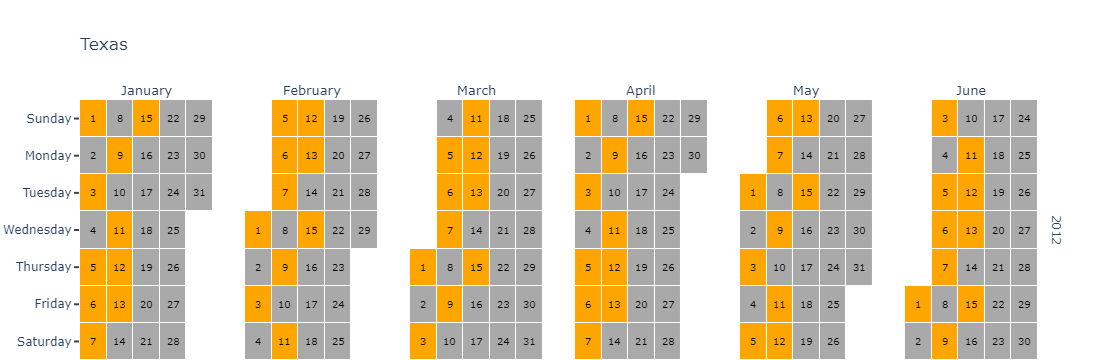

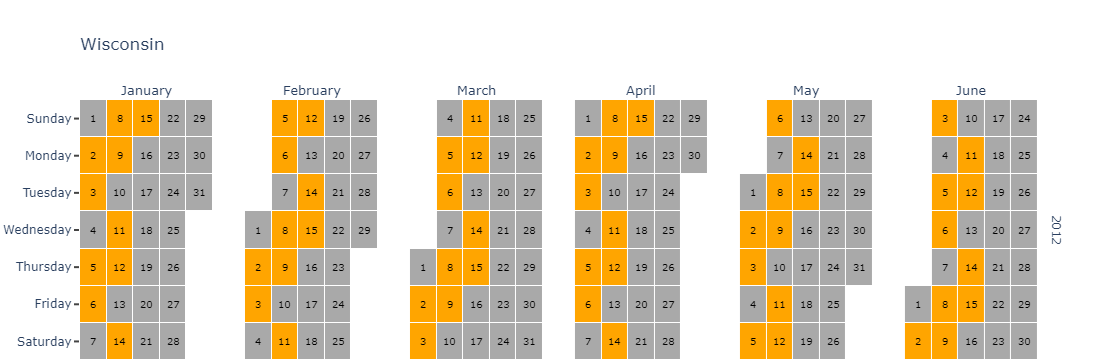

In [474]:
for state, state_ext in zip(["CA", "TX", "WI"], ["California", "Texas", "Wisconsin"]):
    p1 = foo[(foo.year == 2012) & (foo.month <= 6) & (foo.state == state)]
    p1_org = p1[["snap", "month.lbl", "wday.lbl", "mweek"]]
    p1_ext = pd.DataFrame(
        {
            "month.lbl": np.repeat(p1["month.lbl"].unique(), 7 * 5),
            "wday.lbl": np.tile(p1["wday.lbl"].unique(), 6 * 5),
            "mweek": np.tile(np.repeat(p1["mweek"].unique(), 7), 6),
        }
    )
    p1 = pd.merge(p1_ext, p1_org, how="outer")

    fig = make_subplots(rows=1, cols=6, subplot_titles=p1["month.lbl"].unique().tolist())

    zs = p1.snap.values.reshape((6, 5, 7))
    colorscale = [[0, "darkgrey"], [1, "orange"]]
    annotations = []
    mweek = p1["mweek"].unique().tolist()
    wday_lbl = p1["wday.lbl"].unique().tolist()
    annotations = [go.layout.Annotation(font_size=16)] * 6
    for i, z in enumerate(zs):
        text = np.arange(1, 36) - np.nonzero(~np.isnan(z.reshape(-1)))[0][0]
        text = text.reshape(5, 7).T.astype(str)
        text[np.isnan(z.T)] = ""
        subplot = ff.create_annotated_heatmap(
            z.T, x=mweek, y=wday_lbl, annotation_text=text, colorscale=colorscale
        )
        subplot.update_traces(dict(xgap=1, ygap=1))
        fig.add_trace(subplot.data[0], 1, i + 1)
        for annot in subplot.layout.annotations:
            if i > 0:
                annot["xref"] = "x{}".format(i + 1)
                annot["yref"] = "y{}".format(i + 1)
            annot["font"]["size"] = 10
        annotations = annotations + list(subplot.layout.annotations)

    fig.update_xaxes(showticklabels=False, showgrid=False)
    fig.update_yaxes(showticklabels=False, autorange="reversed", showgrid=False)
    fig.update_layout(
        width=800,
        height=250,
        annotations=annotations,
        yaxis=dict(showticklabels=True, ticks="outside", tickwidth=2),
        plot_bgcolor="white",
        title=dict(text=state_ext, xref="paper", x=0),
        margin_b=0,
    )
    for annot in fig.layout.annotations[:6]:
        annot["font"]["size"] = 13
    fig.add_annotation(
        text="2012",
        textangle=90,
        xref="paper",
        yref="paper",
        xanchor="left",
        x=1.01,
        y=0.5,
        showarrow=False,
    )
    if state == "CA":
        fig.add_annotation(
            text="The same SNAP days each month, but different from state to state",
            xref="paper",
            yref="paper",
            xanchor="left",
            x=-0.1,
            y=1.7,
            showarrow=False,
            font_size=20,
        )
    fig.show()

## Item Prices

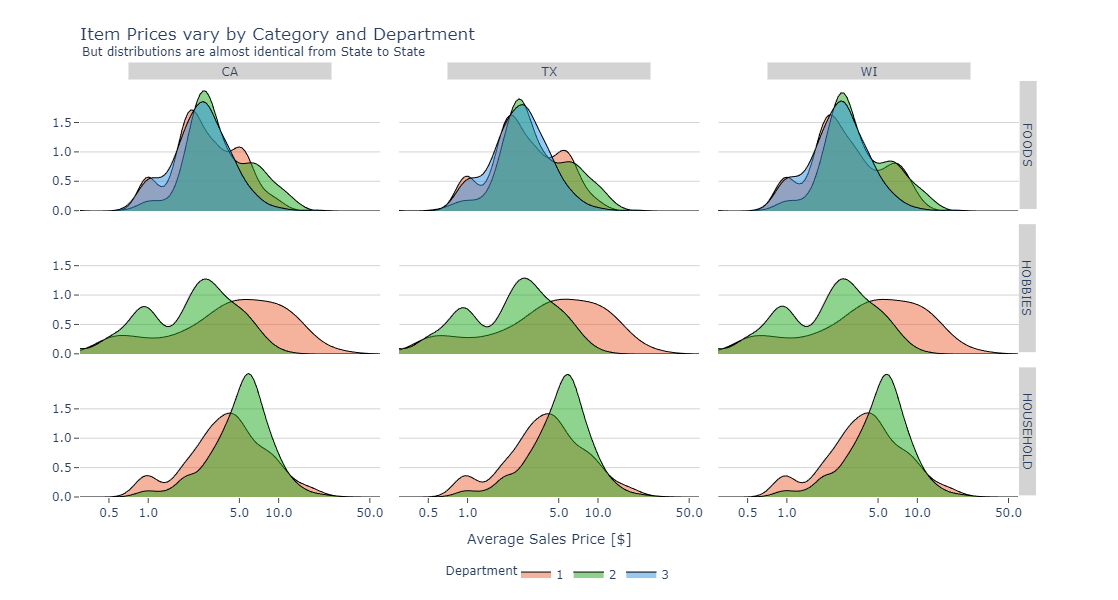

In [224]:
foo = prices.assign(
    cat_id=prices.item_id.str[:-6], dept_id=prices.item_id.str[-5], state=prices.store_id.str[:2]
)
x = np.linspace(np.log10(0.3), np.log10(60), 101)
p = foo.groupby(["state", "cat_id", "dept_id"]).apply(
    lambda data: pd.Series(gaussian_kde(np.log10(data.sell_price), bw_method=0.3)(x))
)
p = p.stack().reset_index()
p["x"] = np.tile(x, p.shape[0] // x.shape[0])

hex_to_rbga = {
    "#EB663B": "rgba(235, 102, 59, 0.5)",
    "#1CA71C": "rgba(28, 167, 28, 0.5)",
    "#2E91E5": "rgba(46, 145, 229, 0.5)",
}
fig = px.line(
    p,
    x="x",
    y=0,
    color="dept_id",
    facet_row="cat_id",
    facet_col="state",
    color_discrete_sequence=ggplot2,
)
fig.update_traces(dict(fill="tozeroy", opacity=1))
fig.for_each_trace(
    lambda a: a.update(fillcolor=hex_to_rbga[a["line"]["color"]], line_color="black", line_width=1)
)
fig.update_xaxes(zeroline=False)
for i in range(1, 4):
    fig.update_xaxes(
        title="",
        tickvals=np.log10(np.array([0.5, 1, 5, 10, 50])),
        ticks="outside",
        ticktext=["0.5", "1.0", "5.0", "10.0", "50.0"],
        row=1,
        col=i,
    )
fig.update_yaxes(gridcolor="lightgray", zeroline=False, tickvals=[0, 0.5, 1, 1.5])
for i in range(1, 4):
    fig.update_yaxes(ticks="outside", title="", tickformat=".1f", row=i, col=1)
fig.for_each_annotation(
    lambda a: a.update(
        text=a.text.split("=")[-1], bgcolor="lightgray", width=200 if a.textangle is None else 125
    )
)
fig.update_layout(
    width=800,
    height=600,
    xaxis2=dict(title="Average Sales Price [$]"),
    plot_bgcolor="white",
    title=dict(text="Item Prices vary by Category and Department", xref="paper", x=0,),
    legend=dict(title="Department", orientation="h", x=0.5, xanchor="center", y=-0.15),
    margin_t=80,
)
fig.add_annotation(
    go.layout.Annotation(
        showarrow=False,
        text="But distributions are almost identical from State to State",
        xref="paper",
        x=0,
        yref="paper",
        y=1.09,
    )
)
fig.show()

In [251]:
foo = prices.assign(
    cat_id=prices.item_id.str[:-6], dept_id=prices.item_id.str[-5], state=prices.store_id.str[:2]
)[["cat_id", "dept_id", "wm_yr_wk", "sell_price"]]
cal = (
    calendar[["date", "wm_yr_wk"]]
    .groupby("wm_yr_wk")
    .apply(lambda x: x[["date"]].iloc[0])
    .reset_index()
)
cal["year"] = cal.date.dt.year
foo = foo.merge(cal, on="wm_yr_wk")

In [275]:
x = np.linspace(np.log10(0.4), np.log10(30), 101)
p = foo.groupby(["dept_id", "cat_id", "year"]).apply(
    lambda data: pd.Series(gaussian_kde(np.log10(data.sell_price), bw_method=0.3)(x))
)
p = p.stack().reset_index()
p["x"] = np.tile(x, p.shape[0] // x.shape[0])

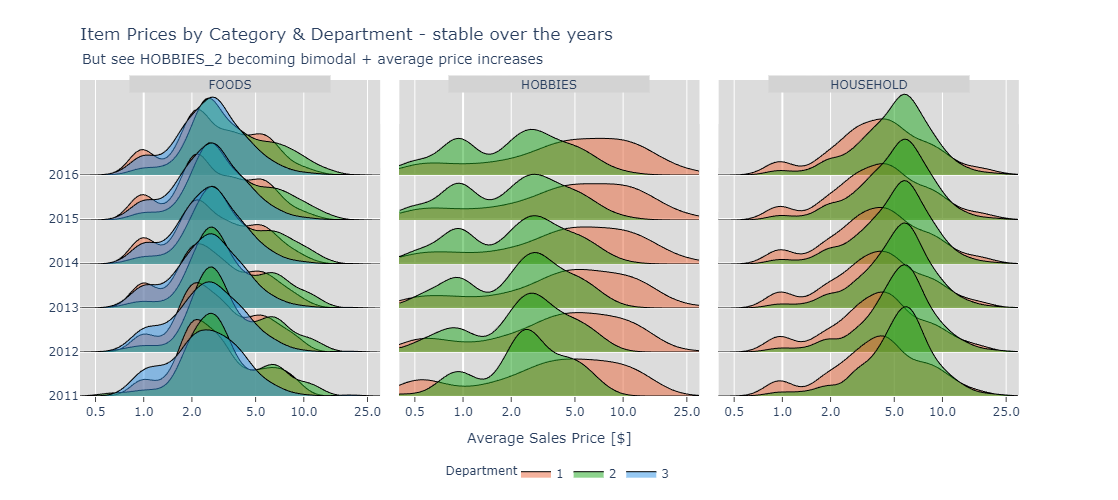

In [411]:
hex_to_rbga = {
    "#EB663B": "rgba(235, 102, 59, 0.5)",
    "#1CA71C": "rgba(28, 167, 28, 0.5)",
    "#2E91E5": "rgba(46, 145, 229, 0.5)",
}
fig = px.line(
    p.sort_values("year", ascending=False, kind="mergesort"),
    x="x",
    y=0,
    color="dept_id",
    facet_col="cat_id",
    facet_row="year",
    color_discrete_sequence=ggplot2,
)
fig.update_xaxes(
    tickvals=np.log10(np.array([0.5, 1, 2, 5, 10, 25])),
    ticktext=["0.5", "1.0", "2.0", "5.0", "10.0", "25.0"],
)
for i in range(1, 4):
    fig.update_xaxes(
        title="" if i != 2 else "Average Sales Price [$]", ticks="outside", row=1, col=i,
    )
fig.update_traces(dict(fill="tozeroy", opacity=1))
fig.for_each_trace(
    lambda a: a.update(fillcolor=hex_to_rbga[a["line"]["color"]], line_color="black", line_width=1)
)
fig.for_each_annotation(
    lambda a: a.update(
        dict(text=a.text.split("=")[-1], bgcolor="lightgray", width=198, y=0.96)
        if "20" not in a.text
        else dict(text="")
    )
)
for i in range(18):
    yaxis = "yaxis" + (str(i + 1) if i > 0 else "")
    fig.update_layout(
        {
            yaxis: dict(
                domain=[i // 3 * 0.14, i // 3 * 0.14 + 0.30],
                title="",
                tickvals=[0],
                ticktext=[str(i // 3 + 2011)],
            )
        }
    )
fig.update_layout(
    width=800,
    height=500,
    title=dict(
        text="Item Prices by Category & Department - stable over the years", xref="paper", x=0,
    ),
    legend=dict(title="Department", orientation="h", x=0.5, xanchor="center", y=-0.2),
    plot_bgcolor="gainsboro",
    margin_t=80,
)
fig.add_annotation(
    go.layout.Annotation(
        showarrow=False,
        text="But see HOBBIES_2 becoming bimodal + average price increases",
        font_size=14,
        xref="paper",
        x=0,
        yref="paper",
        y=1.1,
    )
)
fig.show()

## Connection to time series data